In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='Set2', font_scale=1.6)

## Доверительные интервалы

Рассмотрим доверительные интервалы для параметра сдвига в нормальной модели в случае неизвестной дисперсии: 
 * асимтотический доверительный интервал Вальда
$$\theta \in \bigg(\overline{X}-\frac{S}{\sqrt{n}}z_{(1+\alpha)/2},\ \overline{X}+\frac{S}{\sqrt{n}}z_{(1+\alpha)/2}\bigg)$$
 * точный неасимптотический 
$$\theta \in \bigg(\overline{X} - \frac{S}{\sqrt{n-1}}T_{n-1, (1+\alpha)/2},\ \overline{X} + \frac{S}{\sqrt{n-1}}T_{n-1, (1+\alpha)/2}\bigg)$$

Обозначения:
* $\overline{X} = \frac{1}{n}\sum\limits_{i=1}^n X_i$ &mdash; выборочное среднее;
* $S^2 = \frac{1}{n}\sum\limits_{i=1}^n \left( X_i - \overline{X} \right)^2$ &mdash; выборочная дисперсия;
* $z_{\alpha}$ &mdash; $\alpha$-квантиль распределения $\mathcal{N}(0, 1)$;
* $T_{n-1, (1+\alpha)/2}$ &mdash; $\alpha$-квантиль распределения Стюдента $T_{n-1}$.

---

Напишем функции построения и визуализации интервала

In [3]:
def draw_confidence_interval(
    left,
    right,
    estimation=None,
    sample=None,
    ylim=(None, None),
    color_estimation='#FF3300',
    color_interval='#00CC66',
    color_sample='#0066FF',
    label_estimation='',
    label_interval='',
):
    '''
    Рисует доверительный интервал и оценку в зависимости от размера выборки.

    :param left: левые границы интервалов (в зависимости от n)
    :param right: правые границы интервалов (в зависимости от n)
    :param estimation: оценки (в зависимости от n)
    :param sample: выборка
    :param ylim: ограничение вертикальной оси
    :param color_estimation: цвет оценки
    :param color_interval: цвет интервала
    :param color_sample: цвет выборки
    :param label_estimation: подпись для оценки
    :param label_interval: подпись для интервала
    '''

    time = np.arange(len(left)) + 1

    assert len(time) == len(right)

    if not sample is None:
        plt.scatter(time, sample, alpha=0.3, color=color_sample, s=40, label='Элемент выборки')
    if not estimation is None:
        plt.plot(time, estimation, color=color_estimation, linewidth=2.5, label=label_estimation)

    plt.fill_between(time, left, right, alpha=0.25, color=color_interval, label=label_interval)
    plt.legend()
    plt.ylim(ylim)
    plt.xlabel('Размер выборки')
    plt.title('Зависимость доверительного интервала от размера выборки')

In [4]:
def calculate_confidence_interval(
    sample,
    type='asymptotic',
    alpha=0.95,
    return_estimation=False,
    cumulative=False,
    axis=-1,
):
    '''
    Вычисляет интервал Вальда по выборке.
    :param sample: Массив, содержащий выборки вдоль последней оси
    :param alpha: Уровень доверия
    :param return_estimation: Возвращать ли точечную оценку
    :param cumulative: Считать ли кумулятивные интервалы или только по всей выборке
    
    :return: 
    Если return_estimation==False, то 
        (left, right, estimation) - Границы интервалов
    Если return_estimation==True, то 
        (left, right, estimation) - Границы интервалов и оценка
    '''

    if cumulative:
        sums = np.cumsum(sample, axis=axis)
        sums_sq = np.cumsum(sample**2, axis=axis)
        size = np.arange(sample.shape[axis]) + 1
    else:
        sums = np.sum(sample, axis=axis)
        sums_sq = np.sum(sample**2, axis=axis)
        size = sample.shape[axis]
    
    mean = sums / size
    var = sums_sq / size - mean**2

    if type == 'asymptotic':
        quantile = sps.norm.ppf((1 + alpha) / 2)
        std = np.sqrt(var / size)
    elif type == 'exact':
        quantile = sps.t.ppf((1 + alpha) / 2, df=size-1)
        std = np.sqrt(var / (size-1))
    
    left = mean - quantile * std
    right = mean + quantile * std

    if return_estimation:
        return left, right, mean
    else:
        return left, right


calculate_asymptotic_confidence_interval = partial(
    calculate_confidence_interval,
    type='asymptotic',
)
calculate_exact_confidence_interval = partial(
    calculate_confidence_interval,
    type='exact',
)

Сгенерируем выбору и посчитаем доверительные интервалы по подвыборкам

In [5]:
max_sample_size = 30
sample = np.random.normal(size=max_sample_size)  # выборка
alpha = 0.95  # уровень доверия

In [6]:
left_asymptotic, right_asymptotic, mean = calculate_asymptotic_confidence_interval(
    sample,
    return_estimation=True,
    cumulative=True
)

left_exact, right_exact, mean = calculate_exact_confidence_interval(
    sample,
    return_estimation=True,
    cumulative=True
)

C:\Users\zhark\AppData\Local\Temp/ipykernel_16240/4193641525.py:40: RuntimeWarning: invalid value encountered in true_divide
  std = np.sqrt(var / (size-1))


Визуализируем интервалы

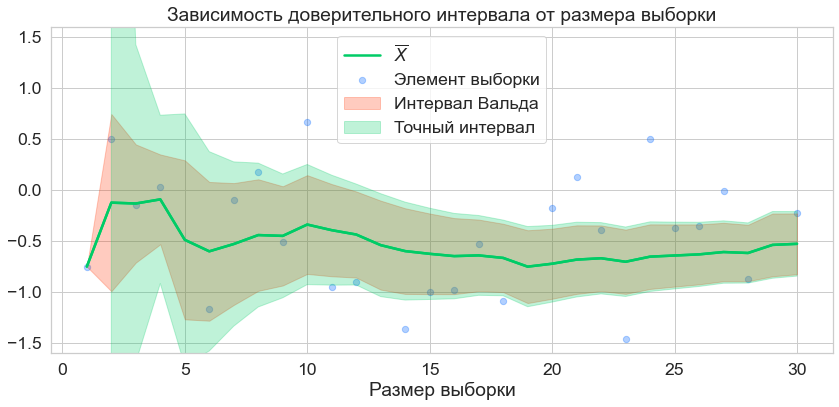

In [7]:
plt.figure(figsize=(14, 6))

draw_confidence_interval(
    left_asymptotic,
    right_asymptotic,
    mean,
    sample,
    ylim=(None, None),
    color_estimation='#00CC66',
    color_interval='#FF3300',
    label_estimation='$\\overline{X}$',
    label_interval='Интервал Вальда',
)

draw_confidence_interval(
    left_exact,
    right_exact,
    mean,
    ylim=(-1.6, 1.6),
    color_estimation='#00CC66',
    color_interval='#00CC66',
    label_interval='Точный интервал',
)

Сравним два исследуемых интервала по величине доли покрытия истинного значения $\theta$

In [8]:
def get_coverage_rate(left, right, theta):
    '''
    Вычисляет долю покрытия параметра доверительным интервалом.
    :param left, right: Массивы левых и правых границ доверительных интервалов
    :param theta: Значение параметра
    '''
    
    return np.mean(
        (left <= theta) & (theta <= right),
        axis=-1,
    )

In [9]:
n_samples = 100_000  # Количество выборок
param_value = 0  # Истинное значение параметра

# Генерируем все выборки
samples = np.random.normal(size=(n_samples, max_sample_size), loc=param_value)

# Считаем интервал Вальда и долю покрытия
left, right = calculate_asymptotic_confidence_interval(samples, cumulative=True)
coverage_rate_asymptotic = get_coverage_rate(left.T, right.T, param_value)

# Считаем интервал на основе максимума и долю покрытия
left, right = calculate_exact_confidence_interval(samples, cumulative=True)
coverage_rate_exact = get_coverage_rate(left.T, right.T, param_value)

C:\Users\zhark\AppData\Local\Temp/ipykernel_16240/4193641525.py:40: RuntimeWarning: invalid value encountered in true_divide
  std = np.sqrt(var / (size-1))


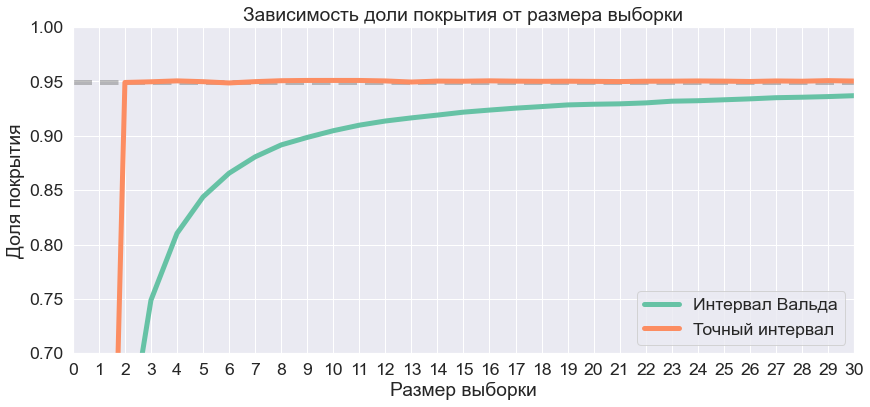

In [10]:
sample_size_grid = np.arange(max_sample_size) + 1

with sns.axes_style('darkgrid'):
    plt.figure(figsize=(14, 6))
    
    plt.plot(sample_size_grid, coverage_rate_asymptotic, lw=5, label='Интервал Вальда')
    plt.plot(sample_size_grid, coverage_rate_exact, lw=5, label='Точный интервал')
    plt.hlines(alpha, 0, max_sample_size, lw=5, color='gray', linestyles='--', alpha=0.5)
    plt.ylim((0.7, 1.0))
    plt.xlim((0, max_sample_size))
    plt.xticks(np.arange(max_sample_size+1))
    plt.legend()
    plt.xlabel('Размер выборки')
    plt.ylabel('Доля покрытия')
    plt.title('Зависимость доли покрытия от размера выборки')

По построенному графику можно сделать вывод, что с увеличением размера выборки асимптотический доверительный интервал становится всё более похожим на точный.

---

*Пример по реальным данным*

In [11]:
data_wine = pd.read_csv('./wine/wine.data', header=None)
data_wine.columns = [
    'Class', 'Alcohol', 'Malic acid',
    'Ash', 'Alcalinity of ash',
    'Magnesium', 'Total phenols',
    'Flavanoids', 'Nonflavanoid phenols',
    'Proanthocyanins', 'Color intensity',
    'Hue', 'OD280/OD315 of diluted wines',
    'Proline'
]

wine_interest = data_wine[[
    'Alcalinity of ash', 
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Hue'
]]
wine_interest = wine_interest[data_wine['Class'] == 1]
wine_matrix = np.array(wine_interest.values).T

FileNotFoundError: [Errno 2] No such file or directory: './wine/wine.data'

Посчитаем доверительные интервалы с применением функций, написанных выше.

In [ ]:
pd.DataFrame(
    calculate_asymptotic_confidence_interval(wine_matrix),
    columns=wine_interest.columns,
    index=['left', 'right']
).T

,left,right
Alcalinity of ash,16.393084,17.681492
Nonflavanoid phenols,0.272278,0.307722
Proanthocyanins,1.795061,2.003583
Hue,1.032564,1.091503


In [ ]:
pd.DataFrame(
    calculate_exact_confidence_interval(wine_matrix),
    columns=wine_interest.columns,
    index=['left', 'right']
).T

,left,right
Alcalinity of ash,16.373713,17.700863
Nonflavanoid phenols,0.271745,0.308255
Proanthocyanins,1.791926,2.006718
Hue,1.031678,1.092389


Мы рассмотрели доверительные интервалы: точный и Вальда для параметра сдвига в нормальной модели в случае неизвестной дисперсии. По построенному графику можно сделать вывод, что с увеличением размера выборки асимптотический доверительный интервал становится всё более похожим на точный. Это подтверждается исследованием четырех признаков вина, где интервалы почти совпадают.